# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy, opencv-python

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [28]:
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import torch.optim as optim
import matplotlib.pyplot as plt

plt_interval = 50

transform = transforms.Compose(
   [transforms.ToTensor()])

# get CIFAR10 dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('tshirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot')

# create binary dataset 
label1 = 2; label2 = 6 # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
trainset.train_data=np.array(trainset.train_data)[mask]
trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == label1)
mask2 = (trainset.train_labels == label2)
trainset.train_labels[mask1] = -1
trainset.train_labels[mask2] = 1

# duplicate train set with horizontal flip and shuffle new array
permutation = np.random.permutation(len(trainset.train_labels))
trainset.train_data = np.concatenate([trainset.train_data, 
                                      np.flip(trainset.train_data[permutation], axis=2).copy()], 0)
trainset.train_labels = np.concatenate([trainset.train_labels, trainset.train_labels[permutation].copy()], 0)

# adjust test set
mask = (testset.test_labels == label1) | (testset.test_labels == label2)
testset.test_data=np.array(testset.test_data)[mask]
testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == label1)
mask2 = (testset.test_labels == label2)
testset.test_labels[mask1] = -1
testset.test_labels[mask2] = 1

# Grayscale and vectorize images
trainset.train_data = torch.from_numpy(trainset.train_data)
testset.test_data = torch.from_numpy(testset.test_data)
print("Dimensions of grayscaled vectorized images:", np.shape(trainset.train_data))



# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("- Test set size:", len(testset))

Dimensions of grayscaled vectorized images: torch.Size([24000, 28, 28])
Data loaded:
- Training set size: 24000
- Test set size: 2000


Test Images:


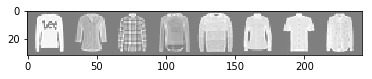

 boot trouser trouser  boot  boot trouser trouser trouser
Train Images:


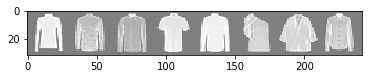

 boot trouser trouser trouser trouser trouser trouser trouser


In [29]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# Weak Learner: Perceptron

In [30]:
# set learning rate
eta = 0.01

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    predict = np.dot(x, weak_learners[i])
    return -1 if (np.sign(predict) < 0) else 1

# update weak learner i
# accepts y in {-1, 1}
def update_WL(weak_learners, x, y, i):
    predict = predict_WL(weak_learners, x, i)
    if (predict*y) < 0:
        weak_learners[i] = weak_learners[i] + eta * x * y
    return weak_learners
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

# Baseline - Weak Learner

In [31]:
def baseline(weak_learner, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    for t, data in enumerate(trainloader, 1):   
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data
        x = x.numpy().flatten()
        predict = -1 if (np.sign(np.dot(x, weak_learner)) < 0) else 1 
        if (predict*y) < 0:
            weak_learner = weak_learner + eta * x * y
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
    
    return np.array(n_mistakes_over_time), weak_learner

# Online BBM 

In [32]:
# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

def onlineBBM(weak_learners, T, gamma):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + y * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability  
            prob = 1 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                update_WL(weak_learners, x, y, j-1)
                
        # evaluate mistakes
        n_mistakes += (y_hat != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
        
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    print("Smallest gamma:", np.min(0.5 - n_mistakes_WL / T))
                
    return n_mistakes_over_time, weak_learners

# AdaBoost OL

In [33]:
def adaboostOL(weak_learners, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = y * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
       
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    print("Smallest gamma:", np.min(0.5 - n_mistakes_WL / T))
    
    return n_mistakes_over_time, alpha

## Evaluate Models on Test Set

In [34]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        for data in testloader:
            x, y = data
            x = x.numpy().flatten()
            prediction = predict_WL(weak_learners, x, i)
            correct += (prediction == y).sum()
        print('Accuracy of weak learner', i, 'on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    for data in testloader: 
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg1(weak_learners, x)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    for data in testloader:
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))

## Evaluate Models Online

In [38]:
def plot_loss(T, mistakes):
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(2*plt_interval, T+1, plt_interval), error_rates[1:])
    plt.title("Fraction of mistakes made online by the strong online learner")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

def evaluate_baseline(T):
    print("\033[1mEvaluating Baseline:\n\033[0m")
    
    weak_learner = np.zeros(784)
    mistakes, weak_learner = baseline(weak_learner, T)
    evaluate_WLs([weak_learner])
    
    plot_loss(T, mistakes)
    
def evaluate_onlineBBM(N, T, gamma):
    print("\033[1mEvaluating Online BBM:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(784)) 
    
    # test
    mistakes, weak_learners = onlineBBM(weak_learners, T, gamma)
    print()
#     evaluate_WLs(weak_learners)
#     print()
    evaluate_model_onlineBBM(weak_learners)
    
    plot_loss(T, mistakes)
    
def evaluate_adaboostOL(N, T, gamma):
    print("\033[1mEvaluating AdaBoost OL:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(784)) 
        
    mistakes, alpha = adaboostOL(weak_learners, T)
#     print()
#     evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    plot_loss(T, mistakes)

## Baseline

Evaluating Baseline:

Fraction of mistakes after 10000 iterations: 0.2436
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 71 %


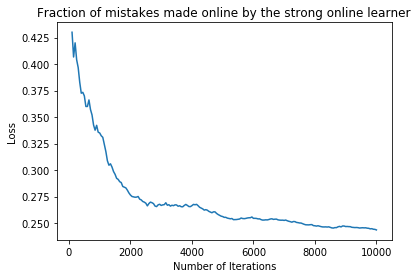

In [38]:
evaluate_baseline(T=10000) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

Evaluating Baseline:

Fraction of mistakes after 2500 iterations: 0.3008
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 66 %


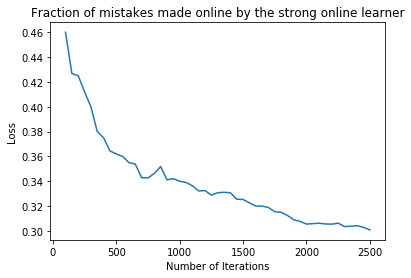

In [39]:
evaluate_baseline(T=2500) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

Evaluating Baseline:

Fraction of mistakes after 5000 iterations: 0.2758
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 62 %


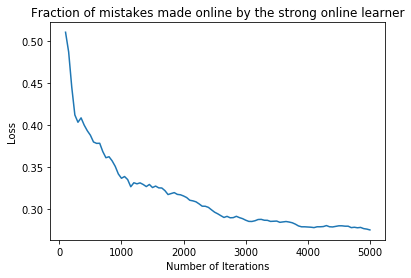

In [79]:
evaluate_baseline(T=5000) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

Evaluating Baseline:

Fraction of mistakes after 20000 iterations: 0.23435
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 73 %


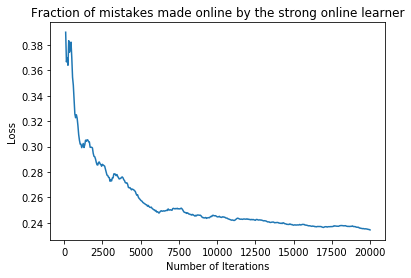

In [41]:
evaluate_baseline(T=20000) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

## Run Experiments

In [39]:
def run_experiment(T=10000, N=10, model="bbm", gamma=0.2):
    evaluate = dict(bbm=evaluate_onlineBBM, adaboost=evaluate_adaboostOL)
    evaluate[model](N, T, gamma)

In [ ]:
run_experiment(T=20000, N=5, model="adaboost", gamma=0.5)

# Online BBM Experiments:

# Different number of weak learners N

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.33
Fraction of mistakes by time 2000 0.28
Fraction of mistakes by time 3000 0.25666666666666665
Fraction of mistakes by time 4000 0.243
Fraction of mistakes by time 5000 0.2356
Fraction of mistakes by time 6000 0.23216666666666666
Fraction of mistakes by time 7000 0.2282857142857143
Fraction of mistakes by time 8000 0.223375
Fraction of mistakes by time 9000 0.22088888888888888
Fraction of mistakes by time 10000 0.2218
Fraction of mistakes after 10000 iterations: 0.2218
Edges of weak learners:
 [0.2555 0.256  0.2658 0.2297]
Smallest gamma: 0.22970000000000002

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 80 %
Accuracy of weak learner 1 on the 2000 test images: 82 %
Accuracy of weak learner 2 on the 2000 test images: 71 %
Accuracy of weak learner 3 on the 2000 test images: 81 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 81 %


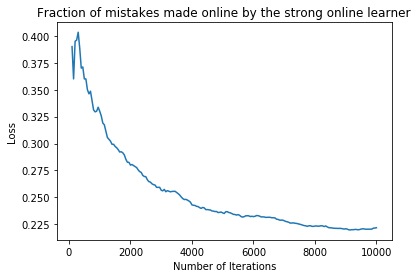

In [81]:
run_experiment(T=10000, N=4, model="bbm", gamma=0.22)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.301
Fraction of mistakes by time 2000 0.2665
Fraction of mistakes by time 3000 0.25033333333333335
Fraction of mistakes by time 4000 0.24425
Fraction of mistakes by time 5000 0.2364
Fraction of mistakes by time 6000 0.23233333333333334
Fraction of mistakes by time 7000 0.2297142857142857
Fraction of mistakes by time 8000 0.226375
Fraction of mistakes by time 9000 0.2238888888888889
Fraction of mistakes by time 10000 0.223
Fraction of mistakes after 10000 iterations: 0.223
Edges of weak learners:
 [0.2525 0.2525 0.2491 0.2495 0.2389 0.2392 0.2195 0.1883]
Smallest gamma: 0.18830000000000002

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 77 %
Accuracy of weak learner 1 on the 2000 test images: 77 %
Accuracy of weak learner 2 on the 2000 test images: 82 %
Accuracy of weak learner 3 on the 2000 test images: 77 %
Accuracy of weak learner 4 on the 2000 test images: 75 %
Accuracy of weak learner 5 on the

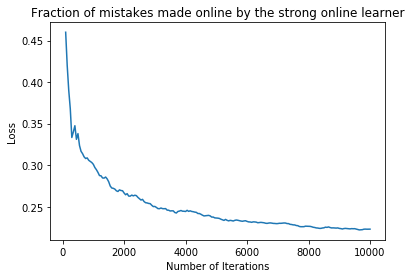

In [10]:
run_experiment(T=10000, N=8, model="bbm", gamma=0.17)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.301
Fraction of mistakes by time 2000 0.284
Fraction of mistakes by time 3000 0.274
Fraction of mistakes by time 4000 0.26875
Fraction of mistakes by time 5000 0.2634
Fraction of mistakes by time 6000 0.25533333333333336
Fraction of mistakes by time 7000 0.24785714285714286
Fraction of mistakes by time 8000 0.244125
Fraction of mistakes by time 9000 0.23944444444444443
Fraction of mistakes by time 10000 0.2397
Fraction of mistakes after 10000 iterations: 0.2397
Edges of weak learners:
 [0.2475 0.2475 0.2475 0.2475 0.2475 0.2475 0.2454 0.2277 0.2063 0.1544
 0.137  0.1194 0.1287 0.115  0.1242 0.1103]
Smallest gamma: 0.11030000000000001

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 82 %
Accuracy of weak learner 1 on the 2000 test images: 82 %
Accuracy of weak learner 2 on the 2000 test images: 82 %
Accuracy of weak learner 3 on the 2000 test images: 82 %
Accuracy of weak learner 4 on the 2000 test 

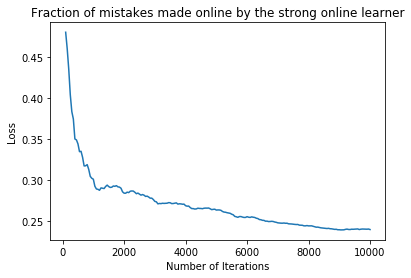

In [12]:
run_experiment(T=10000, N=16, model="bbm", gamma=0.1)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.294
Fraction of mistakes by time 2000 0.2785
Fraction of mistakes by time 3000 0.271
Fraction of mistakes by time 4000 0.26325
Fraction of mistakes by time 5000 0.2566
Fraction of mistakes by time 6000 0.24883333333333332
Fraction of mistakes by time 7000 0.24657142857142858
Fraction of mistakes by time 8000 0.2405
Fraction of mistakes by time 9000 0.237
Fraction of mistakes by time 10000 0.2359
Fraction of mistakes after 10000 iterations: 0.2359
Edges of weak learners:
 [0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2573 0.2365 0.224  0.1873 0.1695 0.1197 0.1374 0.0988 0.0815
 0.1018 0.0633 0.0772 0.0563 0.0999 0.0542 0.1191 0.0967 0.1052 0.1189
 0.1185 0.0689]
Smallest gamma: 0.054200000000000026

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 79 %
Accuracy of weak learner 1 on the 2000 test images: 79 %
Accuracy of weak learner 2 on the 2000 test images: 79 %
A

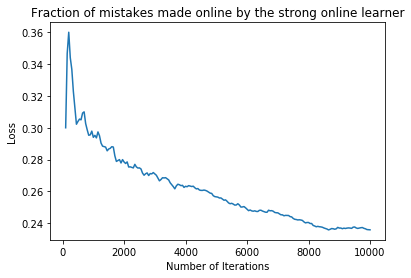

In [13]:
run_experiment(T=10000, N=32, model="bbm", gamma=0.05)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.312
Fraction of mistakes by time 2000 0.288
Fraction of mistakes by time 3000 0.2823333333333333
Fraction of mistakes by time 4000 0.272
Fraction of mistakes by time 5000 0.2634
Fraction of mistakes by time 6000 0.2555
Fraction of mistakes by time 7000 0.2537142857142857
Fraction of mistakes by time 8000 0.251125
Fraction of mistakes by time 9000 0.24844444444444444
Fraction of mistakes by time 10000 0.2446
Fraction of mistakes after 10000 iterations: 0.2446
Edges of weak learners:
 [0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554 0.2554
 0.2554 0.2554 0.2747 0.24   0.2145 0.1782 0.1748 0.1481 0.1304 0.1089
 0.1092 0.1402 0.1543 0.1772 0.189  0.1762 0.1648 0.1895 0.2208 0.1973
 0.2087 0.1571 0.1369 0.1789 0.1879 0.2146 0.2047 0.2279 0.2437 0.2169
 0.2286 0.2631 0.262  0.25

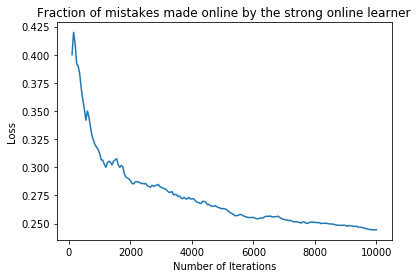

In [47]:
run_experiment(T=10000, N=64, model="bbm", gamma=0.08)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.334
Fraction of mistakes by time 2000 0.302
Fraction of mistakes by time 3000 0.283
Fraction of mistakes by time 4000 0.27575
Fraction of mistakes by time 5000 0.2666
Fraction of mistakes by time 6000 0.2565
Fraction of mistakes by time 7000 0.25557142857142856
Fraction of mistakes by time 8000 0.25325
Fraction of mistakes by time 9000 0.24855555555555556
Fraction of mistakes by time 10000 0.2478
Fraction of mistakes after 10000 iterations: 0.2478
Edges of weak learners:
 [0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522
 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522
 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522
 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522
 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522
 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522 0.2522
 0.2522 0.2522 0.2522 0.2522 0.2609 0

Accuracy of weak learner 116 on the 2000 test images: 78 %
Accuracy of weak learner 117 on the 2000 test images: 78 %
Accuracy of weak learner 118 on the 2000 test images: 78 %
Accuracy of weak learner 119 on the 2000 test images: 78 %
Accuracy of weak learner 120 on the 2000 test images: 78 %
Accuracy of weak learner 121 on the 2000 test images: 78 %
Accuracy of weak learner 122 on the 2000 test images: 78 %
Accuracy of weak learner 123 on the 2000 test images: 78 %
Accuracy of weak learner 124 on the 2000 test images: 78 %
Accuracy of weak learner 125 on the 2000 test images: 78 %
Accuracy of weak learner 126 on the 2000 test images: 78 %
Accuracy of weak learner 127 on the 2000 test images: 78 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 78 %


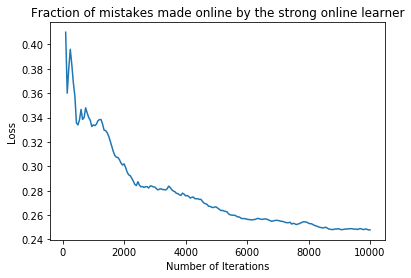

In [48]:
run_experiment(T=10000, N=128, model="bbm", gamma=0.0735)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.33
Fraction of mistakes by time 2000 0.295
Fraction of mistakes by time 3000 0.2833333333333333
Fraction of mistakes by time 4000 0.28175
Fraction of mistakes by time 5000 0.2762
Fraction of mistakes by time 6000 0.2653333333333333
Fraction of mistakes by time 7000 0.25671428571428573
Fraction of mistakes by time 8000 0.254625
Fraction of mistakes by time 9000 0.25333333333333335
Fraction of mistakes by time 10000 0.25
Fraction of mistakes after 10000 iterations: 0.25
Edges of weak learners:
 [0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
 0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
 0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
 0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
 0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
 0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25   0.25
 0.25   0.25   0.25   0.25  

Accuracy of weak learner 70 on the 2000 test images: 74 %
Accuracy of weak learner 71 on the 2000 test images: 74 %
Accuracy of weak learner 72 on the 2000 test images: 74 %
Accuracy of weak learner 73 on the 2000 test images: 74 %
Accuracy of weak learner 74 on the 2000 test images: 74 %
Accuracy of weak learner 75 on the 2000 test images: 74 %
Accuracy of weak learner 76 on the 2000 test images: 74 %
Accuracy of weak learner 77 on the 2000 test images: 74 %
Accuracy of weak learner 78 on the 2000 test images: 74 %
Accuracy of weak learner 79 on the 2000 test images: 74 %
Accuracy of weak learner 80 on the 2000 test images: 74 %
Accuracy of weak learner 81 on the 2000 test images: 74 %
Accuracy of weak learner 82 on the 2000 test images: 74 %
Accuracy of weak learner 83 on the 2000 test images: 74 %
Accuracy of weak learner 84 on the 2000 test images: 74 %
Accuracy of weak learner 85 on the 2000 test images: 74 %
Accuracy of weak learner 86 on the 2000 test images: 74 %
Accuracy of we

Accuracy of weak learner 210 on the 2000 test images: 74 %
Accuracy of weak learner 211 on the 2000 test images: 74 %
Accuracy of weak learner 212 on the 2000 test images: 74 %
Accuracy of weak learner 213 on the 2000 test images: 74 %
Accuracy of weak learner 214 on the 2000 test images: 74 %
Accuracy of weak learner 215 on the 2000 test images: 74 %
Accuracy of weak learner 216 on the 2000 test images: 74 %
Accuracy of weak learner 217 on the 2000 test images: 74 %
Accuracy of weak learner 218 on the 2000 test images: 74 %
Accuracy of weak learner 219 on the 2000 test images: 74 %
Accuracy of weak learner 220 on the 2000 test images: 74 %
Accuracy of weak learner 221 on the 2000 test images: 74 %
Accuracy of weak learner 222 on the 2000 test images: 74 %
Accuracy of weak learner 223 on the 2000 test images: 74 %
Accuracy of weak learner 224 on the 2000 test images: 74 %
Accuracy of weak learner 225 on the 2000 test images: 74 %
Accuracy of weak learner 226 on the 2000 test images: 74

Accuracy of weak learner 349 on the 2000 test images: 74 %
Accuracy of weak learner 350 on the 2000 test images: 74 %
Accuracy of weak learner 351 on the 2000 test images: 74 %
Accuracy of weak learner 352 on the 2000 test images: 74 %
Accuracy of weak learner 353 on the 2000 test images: 74 %
Accuracy of weak learner 354 on the 2000 test images: 74 %
Accuracy of weak learner 355 on the 2000 test images: 74 %
Accuracy of weak learner 356 on the 2000 test images: 74 %
Accuracy of weak learner 357 on the 2000 test images: 74 %
Accuracy of weak learner 358 on the 2000 test images: 74 %
Accuracy of weak learner 359 on the 2000 test images: 74 %
Accuracy of weak learner 360 on the 2000 test images: 74 %
Accuracy of weak learner 361 on the 2000 test images: 74 %
Accuracy of weak learner 362 on the 2000 test images: 74 %
Accuracy of weak learner 363 on the 2000 test images: 74 %
Accuracy of weak learner 364 on the 2000 test images: 74 %
Accuracy of weak learner 365 on the 2000 test images: 74

Accuracy of weak learner 488 on the 2000 test images: 74 %
Accuracy of weak learner 489 on the 2000 test images: 74 %
Accuracy of weak learner 490 on the 2000 test images: 74 %
Accuracy of weak learner 491 on the 2000 test images: 74 %
Accuracy of weak learner 492 on the 2000 test images: 74 %
Accuracy of weak learner 493 on the 2000 test images: 74 %
Accuracy of weak learner 494 on the 2000 test images: 74 %
Accuracy of weak learner 495 on the 2000 test images: 74 %
Accuracy of weak learner 496 on the 2000 test images: 74 %
Accuracy of weak learner 497 on the 2000 test images: 74 %
Accuracy of weak learner 498 on the 2000 test images: 74 %
Accuracy of weak learner 499 on the 2000 test images: 74 %
Accuracy of weak learner 500 on the 2000 test images: 74 %
Accuracy of weak learner 501 on the 2000 test images: 74 %
Accuracy of weak learner 502 on the 2000 test images: 74 %
Accuracy of weak learner 503 on the 2000 test images: 74 %
Accuracy of weak learner 504 on the 2000 test images: 74

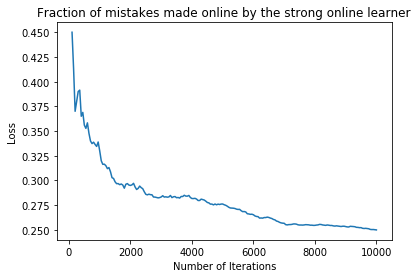

In [37]:
run_experiment(T=10000, N=512, model="bbm", gamma=0.02)

# Different number of iterations T

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.294
Fraction of mistakes by time 2000 0.281
Fraction of mistakes after 2500 iterations: 0.2724
Edges of weak learners:
 [0.21   0.21   0.21   0.21   0.21   0.2124 0.1932 0.174  0.1648 0.1444
 0.1148 0.1428 0.1692 0.1268 0.1408 0.1352]
Smallest gamma: 0.11480000000000001

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 81 %
Accuracy of weak learner 1 on the 2000 test images: 81 %
Accuracy of weak learner 2 on the 2000 test images: 81 %
Accuracy of weak learner 3 on the 2000 test images: 81 %
Accuracy of weak learner 4 on the 2000 test images: 81 %
Accuracy of weak learner 5 on the 2000 test images: 77 %
Accuracy of weak learner 6 on the 2000 test images: 80 %
Accuracy of weak learner 7 on the 2000 test images: 58 %
Accuracy of weak learner 8 on the 2000 test images: 78 %
Accuracy of weak learner 9 on the 2000 test images: 69 %
Accuracy of weak learner 10 on the 2000 test images: 63 %
Accuracy of wea

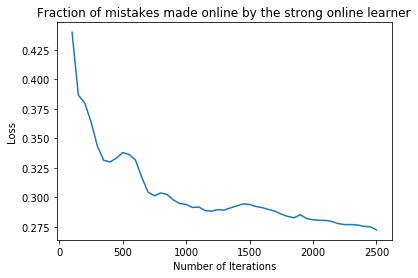

In [16]:
run_experiment(T=2500, N=16, model="bbm", gamma=0.09)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.271
Fraction of mistakes by time 2000 0.246
Fraction of mistakes by time 3000 0.243
Fraction of mistakes by time 4000 0.235
Fraction of mistakes by time 5000 0.2316
Fraction of mistakes after 5000 iterations: 0.2316
Edges of weak learners:
 [0.2542 0.2542 0.2542 0.2542 0.2542 0.2542 0.2432 0.2314 0.1952 0.1724
 0.1416 0.167  0.1246 0.1096 0.1362 0.1328]
Smallest gamma: 0.10959999999999998

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 59 %
Accuracy of weak learner 1 on the 2000 test images: 59 %
Accuracy of weak learner 2 on the 2000 test images: 59 %
Accuracy of weak learner 3 on the 2000 test images: 59 %
Accuracy of weak learner 4 on the 2000 test images: 59 %
Accuracy of weak learner 5 on the 2000 test images: 59 %
Accuracy of weak learner 6 on the 2000 test images: 77 %
Accuracy of weak learner 7 on the 2000 test images: 59 %
Accuracy of weak learner 8 on the 2000 test images: 78 %
Accuracy 

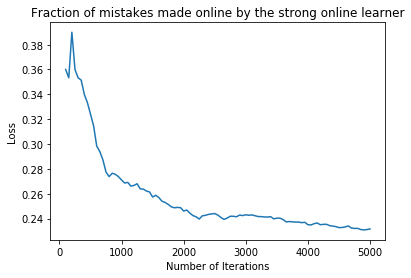

In [23]:
run_experiment(T=5000, N=16, model="bbm", gamma=0.1)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.344
Fraction of mistakes by time 2000 0.2995
Fraction of mistakes by time 3000 0.2803333333333333
Fraction of mistakes by time 4000 0.27025
Fraction of mistakes by time 5000 0.2666
Fraction of mistakes by time 6000 0.25366666666666665
Fraction of mistakes by time 7000 0.249
Fraction of mistakes by time 8000 0.24225
Fraction of mistakes by time 9000 0.23766666666666666
Fraction of mistakes by time 10000 0.2345
Fraction of mistakes by time 11000 0.23136363636363635
Fraction of mistakes by time 12000 0.2295
Fraction of mistakes by time 13000 0.2286153846153846
Fraction of mistakes by time 14000 0.22607142857142856
Fraction of mistakes by time 15000 0.22593333333333335
Fraction of mistakes by time 16000 0.223125
Fraction of mistakes by time 17000 0.22141176470588236
Fraction of mistakes by time 18000 0.22033333333333333
Fraction of mistakes by time 19000 0.21894736842105264
Fraction of mistakes by time 20000 0.21735
Fraction of mi

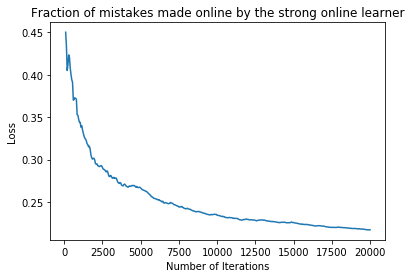

In [27]:
run_experiment(T=20000, N=16, model="bbm", gamma=0.1)

# Online BBM Experiments:

# Different number of weak learners N

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.345
Fraction of mistakes by time 2000 0.316
Fraction of mistakes by time 3000 0.302
Fraction of mistakes by time 4000 0.29125
Fraction of mistakes by time 5000 0.2814
Fraction of mistakes by time 6000 0.2768333333333333
Fraction of mistakes by time 7000 0.2734285714285714
Fraction of mistakes by time 8000 0.267875
Fraction of mistakes by time 9000 0.266
Fraction of mistakes by time 10000 0.2631
Fraction of mistakes after 10000 iterations: 0.2631
Edges of weak learners:
 [0.2352 0.1985 0.2041 0.1825]
Smallest gamma: 0.1825

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 76 %
Accuracy of weak learner 1 on the 2000 test images: 69 %
Accuracy of weak learner 2 on the 2000 test images: 75 %
Accuracy of weak learner 3 on the 2000 test images: 75 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 76 %


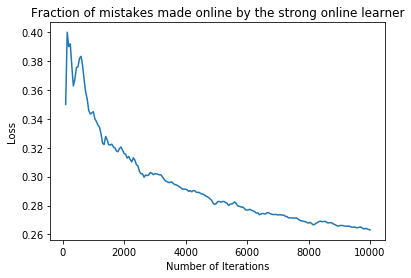

In [52]:
run_experiment(T=10000, N=4, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.362
Fraction of mistakes by time 2000 0.317
Fraction of mistakes by time 3000 0.30366666666666664
Fraction of mistakes by time 4000 0.29425
Fraction of mistakes by time 5000 0.2838
Fraction of mistakes by time 6000 0.27616666666666667
Fraction of mistakes by time 7000 0.27185714285714285
Fraction of mistakes by time 8000 0.263875
Fraction of mistakes by time 9000 0.2618888888888889
Fraction of mistakes by time 10000 0.2605
Fraction of mistakes after 10000 iterations: 0.2605
Edges of weak learners:
 [0.2322 0.2105 0.2025 0.1909 0.1907 0.1914 0.1825 0.1804]
Smallest gamma: 0.1804

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 81 %
Accuracy of weak learner 1 on the 2000 test images: 81 %
Accuracy of weak learner 2 on the 2000 test images: 80 %
Accuracy of weak learner 3 on the 2000 test images: 71 %
Accuracy of weak learner 4 on the 2000 test images: 66 %
Accuracy of weak learner 5 on the 2000 test

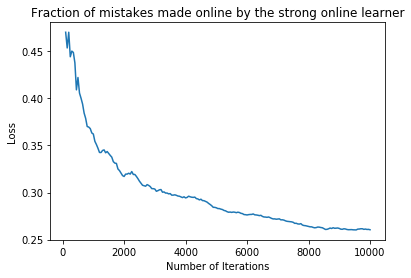

In [53]:
run_experiment(T=10000, N=8, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.339
Fraction of mistakes by time 2000 0.3025
Fraction of mistakes by time 3000 0.2833333333333333
Fraction of mistakes by time 4000 0.27425
Fraction of mistakes by time 5000 0.2682
Fraction of mistakes by time 6000 0.26566666666666666
Fraction of mistakes by time 7000 0.268
Fraction of mistakes by time 8000 0.26175
Fraction of mistakes by time 9000 0.26122222222222224
Fraction of mistakes by time 10000 0.2559
Fraction of mistakes after 10000 iterations: 0.2559
Edges of weak learners:
 [0.2399 0.1993 0.1975 0.1866 0.1927 0.1794 0.1725 0.1801 0.1787 0.1613
 0.1905 0.1661 0.1766 0.1725 0.1769 0.1701]
Smallest gamma: 0.1613

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 50 %
Accuracy of weak learner 1 on the 2000 test images: 79 %
Accuracy of weak learner 2 on the 2000 test images: 75 %
Accuracy of weak learner 3 on the 2000 test images: 57 %
Accuracy of weak learner 4 on the 2000 test images: 51 %


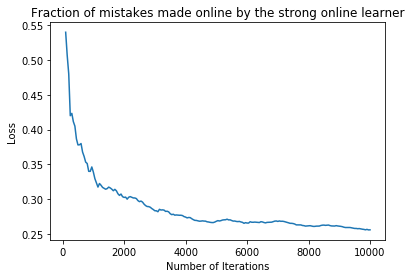

In [ ]:
run_experiment(T=10000, N=16, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.37
Fraction of mistakes by time 2000 0.3255
Fraction of mistakes by time 3000 0.31933333333333336
Fraction of mistakes by time 4000 0.2995
Fraction of mistakes by time 5000 0.291
Fraction of mistakes by time 6000 0.283
Fraction of mistakes by time 7000 0.2782857142857143
Fraction of mistakes by time 8000 0.271375
Fraction of mistakes by time 9000 0.2668888888888889
Fraction of mistakes by time 10000 0.2644
Fraction of mistakes after 10000 iterations: 0.2644
Edges of weak learners:
 [0.2327 0.2099 0.1962 0.1886 0.1854 0.188  0.1893 0.1805 0.1779 0.1891
 0.1848 0.1848 0.1783 0.1812 0.1845 0.182  0.1803 0.1816 0.1808 0.1861
 0.1836 0.1772 0.1866 0.1808 0.1774 0.1731 0.1901 0.1795 0.1803 0.1901
 0.1729 0.1882]
Smallest gamma: 0.1729

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 79 %
Accuracy of weak learner 1 on the 2000 test images: 81 %
Accuracy of weak learner 2 on the 2000 test images: 81 %
Acc

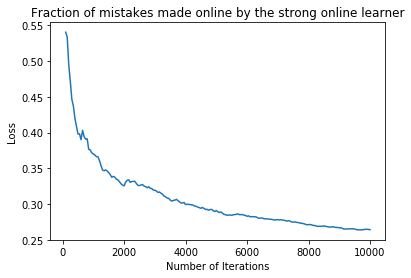

In [71]:
run_experiment(T=10000, N=32, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.403
Fraction of mistakes by time 2000 0.349
Fraction of mistakes by time 3000 0.323
Fraction of mistakes by time 4000 0.3005
Fraction of mistakes by time 5000 0.2918
Fraction of mistakes by time 6000 0.2896666666666667
Fraction of mistakes by time 7000 0.2824285714285714
Fraction of mistakes by time 8000 0.277
Fraction of mistakes by time 9000 0.27311111111111114
Fraction of mistakes by time 10000 0.2705
Fraction of mistakes after 10000 iterations: 0.2705
Edges of weak learners:
 [0.2274 0.1971 0.191  0.1908 0.1793 0.1805 0.1737 0.1851 0.1824 0.1796
 0.1765 0.1874 0.1916 0.1842 0.1901 0.1901 0.1821 0.18   0.1732 0.176
 0.1821 0.1743 0.182  0.1805 0.1732 0.1789 0.1857 0.182  0.1737 0.1799
 0.1786 0.1756 0.1813 0.1826 0.1812 0.1602 0.1734 0.1673 0.1801 0.1748
 0.185  0.1719 0.1705 0.1771 0.1745 0.1721 0.1868 0.1834 0.1864 0.172
 0.1768 0.175  0.1768 0.1817 0.1751 0.1748 0.1859 0.1708 0.1833 0.1829
 0.1808 0.1763 0.1819 0.186 ]


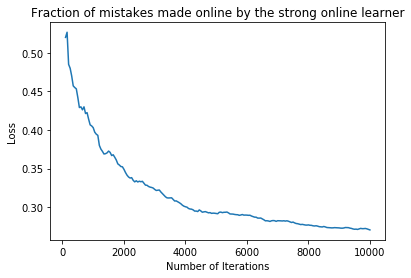

In [72]:
run_experiment(T=10000, N=64, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.353
Fraction of mistakes by time 2000 0.3295
Fraction of mistakes by time 3000 0.32366666666666666
Fraction of mistakes by time 4000 0.31425
Fraction of mistakes by time 5000 0.3072
Fraction of mistakes by time 6000 0.29833333333333334
Fraction of mistakes by time 7000 0.2934285714285714
Fraction of mistakes by time 8000 0.28825
Fraction of mistakes by time 9000 0.28444444444444444
Fraction of mistakes by time 10000 0.283
Fraction of mistakes after 10000 iterations: 0.283
Edges of weak learners:
 [0.2361 0.2008 0.191  0.195  0.1914 0.185  0.1961 0.187  0.1766 0.1787
 0.1752 0.1792 0.1962 0.1765 0.1774 0.1778 0.1782 0.1876 0.1865 0.1886
 0.1814 0.1807 0.1792 0.1822 0.1825 0.1841 0.1694 0.1782 0.1821 0.1879
 0.1833 0.1762 0.1787 0.1723 0.1779 0.1898 0.1837 0.1783 0.1783 0.1834
 0.1809 0.1776 0.1684 0.1825 0.1753 0.1751 0.1796 0.1792 0.1807 0.1776
 0.1674 0.1752 0.1696 0.1778 0.1752 0.1751 0.1934 0.1881 0.178  0.1769
 0.1829 0.1

Accuracy of weak learner 115 on the 2000 test images: 60 %
Accuracy of weak learner 116 on the 2000 test images: 56 %
Accuracy of weak learner 117 on the 2000 test images: 50 %
Accuracy of weak learner 118 on the 2000 test images: 60 %
Accuracy of weak learner 119 on the 2000 test images: 61 %
Accuracy of weak learner 120 on the 2000 test images: 52 %
Accuracy of weak learner 121 on the 2000 test images: 55 %
Accuracy of weak learner 122 on the 2000 test images: 60 %
Accuracy of weak learner 123 on the 2000 test images: 61 %
Accuracy of weak learner 124 on the 2000 test images: 63 %
Accuracy of weak learner 125 on the 2000 test images: 55 %
Accuracy of weak learner 126 on the 2000 test images: 51 %
Accuracy of weak learner 127 on the 2000 test images: 64 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 54 %


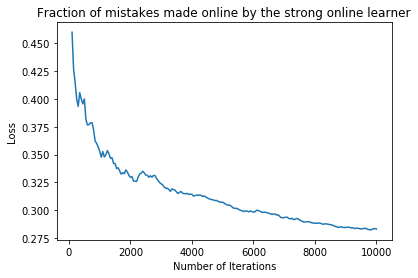

In [73]:
run_experiment(T=10000, N=128, model="adaboost")

# Different number of iterations T

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.375
Fraction of mistakes by time 2000 0.327
Fraction of mistakes after 2500 iterations: 0.3108
Edges of weak learners:
 [0.1848 0.1596 0.1468 0.1548 0.1612 0.144  0.1196 0.1428]
Smallest gamma: 0.11959999999999998

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 79 %
Accuracy of weak learner 1 on the 2000 test images: 53 %
Accuracy of weak learner 2 on the 2000 test images: 75 %
Accuracy of weak learner 3 on the 2000 test images: 76 %
Accuracy of weak learner 4 on the 2000 test images: 59 %
Accuracy of weak learner 5 on the 2000 test images: 56 %
Accuracy of weak learner 6 on the 2000 test images: 55 %
Accuracy of weak learner 7 on the 2000 test images: 73 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 76 %


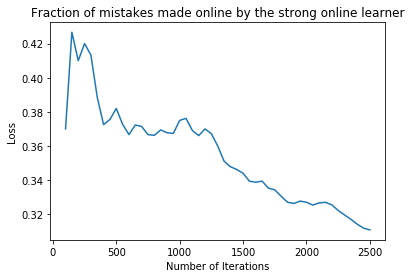

In [75]:
run_experiment(T=2500, N=8, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.351
Fraction of mistakes by time 2000 0.307
Fraction of mistakes by time 3000 0.2916666666666667
Fraction of mistakes by time 4000 0.285
Fraction of mistakes by time 5000 0.2778
Fraction of mistakes after 5000 iterations: 0.2778
Edges of weak learners:
 [0.2194 0.2024 0.1894 0.1806 0.181  0.1756 0.1796 0.1836]
Smallest gamma: 0.17559999999999998

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 82 %
Accuracy of weak learner 1 on the 2000 test images: 60 %
Accuracy of weak learner 2 on the 2000 test images: 79 %
Accuracy of weak learner 3 on the 2000 test images: 74 %
Accuracy of weak learner 4 on the 2000 test images: 77 %
Accuracy of weak learner 5 on the 2000 test images: 60 %
Accuracy of weak learner 6 on the 2000 test images: 81 %
Accuracy of weak learner 7 on the 2000 test images: 77 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 82 %


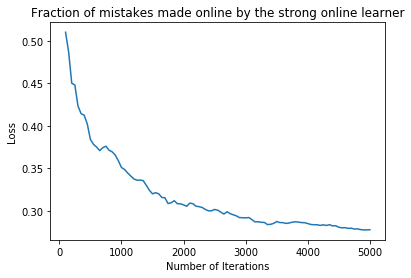

In [76]:
run_experiment(T=5000, N=8, model="adaboost")

Evaluating AdaBoost OL:

Fraction of mistakes by time 1000 0.381
Fraction of mistakes by time 2000 0.3265
Fraction of mistakes by time 3000 0.30566666666666664
Fraction of mistakes by time 4000 0.28975
Fraction of mistakes by time 5000 0.2846
Fraction of mistakes by time 6000 0.277
Fraction of mistakes by time 7000 0.273
Fraction of mistakes by time 8000 0.2685
Fraction of mistakes by time 9000 0.26066666666666666
Fraction of mistakes by time 10000 0.257
Fraction of mistakes by time 11000 0.25527272727272726
Fraction of mistakes by time 12000 0.2525
Fraction of mistakes by time 13000 0.25153846153846154
Fraction of mistakes by time 14000 0.24964285714285714
Fraction of mistakes by time 15000 0.2484
Fraction of mistakes by time 16000 0.2468125
Fraction of mistakes by time 17000 0.24658823529411764
Fraction of mistakes by time 18000 0.2442777777777778
Fraction of mistakes by time 19000 0.2433157894736842
Fraction of mistakes by time 20000 0.2425
Fraction of mistakes after 20000 iteration

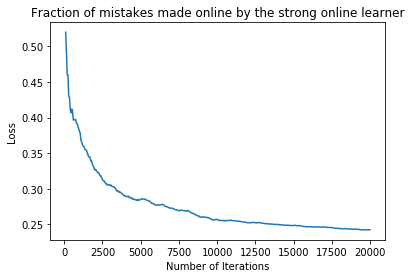

In [77]:
run_experiment(T=20000, N=8, model="adaboost")

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf